# Importing libraries

In [2]:
import os
import re

import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import Audio
from keras import layers
from keras import models
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import pickle
import itertools
import visualkeras

In [3]:
# Path to Audio Files

Crema = "C:/Users/rahul/final_d/"

# Data preparation

CREMA-D is a data set of 7,442 original clips from 91 actors. These clips were from 48 male and 43 female actors between the ages of 20 and 74 coming from a variety of races and ethnicities (African America, Asian, Caucasian, Hispanic, and Unspecified). Actors spoke from a selection of 12 sentences. The sentences were presented using one of six different emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad) and four different emotion levels (Low, Medium, High, and Unspecified).

Happiness: Customers may exhibit happiness and satisfaction when they perceive that the agent is successfully resolving their issue or providing excellent service. 
    Positive outcomes, prompt assistance, and friendly agents can lead to this sentiment.

Sadness: If customers feel that their problem remains unresolved or that they have received poor service, 
    they may express sadness, disappointment, or frustration. This sentiment can also arise from situations 
    like product defects or unexpected issues.

Neutrality: Some customers may remain neutral throughout the interaction, especially when the issue is routine or non-emotional. 
    They may not express strong positive or negative sentiments.

Disgust: Customers who encounter unprofessional behavior, incompetence, or a lack of empathy 
    from agents may exhibit disgust or dissatisfaction. This sentiment can be triggered by a perceived failure 
    in service quality.

Fear: In some cases, customers may feel anxious or fearful about the outcome of their interaction. 
    This can occur when they are dealing with complex or critical issues, such as financial matters or health-related concerns.

Anger: When customers believe that their concerns are not being addressed adequately, they may become angry. 
    This sentiment can manifest as frustration, irritation, or even hostile behavior toward the agent.



In [4]:
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))


Crema_df = pd.DataFrame.from_dict(emotion_df)
Crema_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

Crema_df.head()

,Emotion,Path
0,angry,C:/Users/rahul/final_d//1001_DFA_ANG_XX.wav
1,disgust,C:/Users/rahul/final_d//1001_DFA_DIS_XX.wav
2,fear,C:/Users/rahul/final_d//1001_DFA_FEA_XX.wav
3,happy,C:/Users/rahul/final_d//1001_DFA_HAP_XX.wav
4,neutral,C:/Users/rahul/final_d//1001_DFA_NEU_XX.wav


In [5]:
df = Crema_df.copy()
df.shape
df.head(10)

,Emotion,Path
0,angry,C:/Users/rahul/final_d//1001_DFA_ANG_XX.wav
1,disgust,C:/Users/rahul/final_d//1001_DFA_DIS_XX.wav
2,fear,C:/Users/rahul/final_d//1001_DFA_FEA_XX.wav
3,happy,C:/Users/rahul/final_d//1001_DFA_HAP_XX.wav
4,neutral,C:/Users/rahul/final_d//1001_DFA_NEU_XX.wav
5,sad,C:/Users/rahul/final_d//1001_DFA_SAD_XX.wav
6,angry,C:/Users/rahul/final_d//1001_IEO_ANG_HI.wav
7,angry,C:/Users/rahul/final_d//1001_IEO_ANG_LO.wav
8,angry,C:/Users/rahul/final_d//1001_IEO_ANG_MD.wav
9,disgust,C:/Users/rahul/final_d//1001_IEO_DIS_HI.wav


# Exploratory Data Analysis

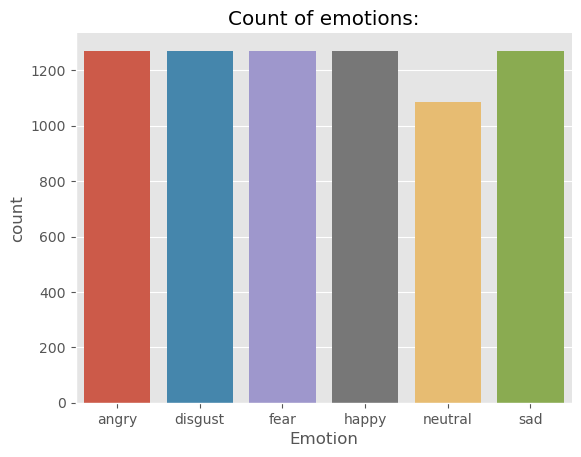

In [6]:
%matplotlib inline

plt.style.use("ggplot")

plt.title("Count of emotions:")
sns.countplot(x=df["Emotion"])
sns.despine(top=True, right=True, left=False, bottom=False)

In [7]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveshow(data, sr=sr, color="purple")
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

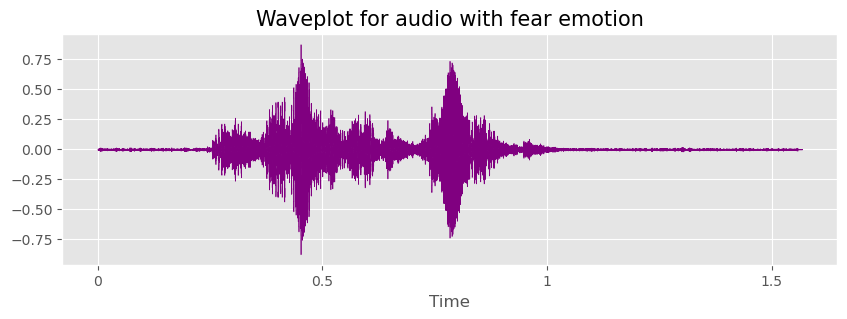

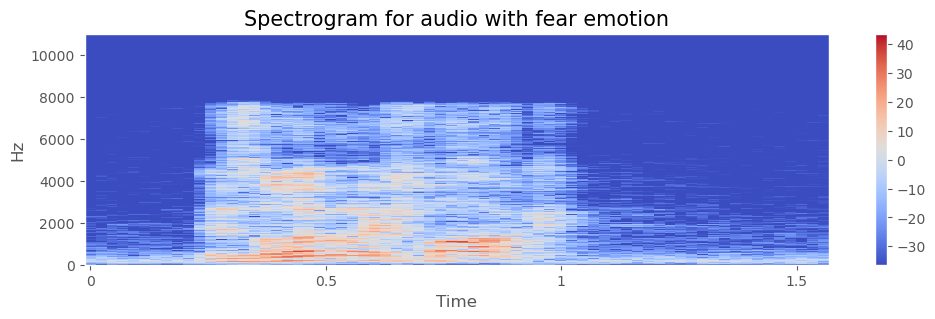

In [8]:
emotion='fear'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

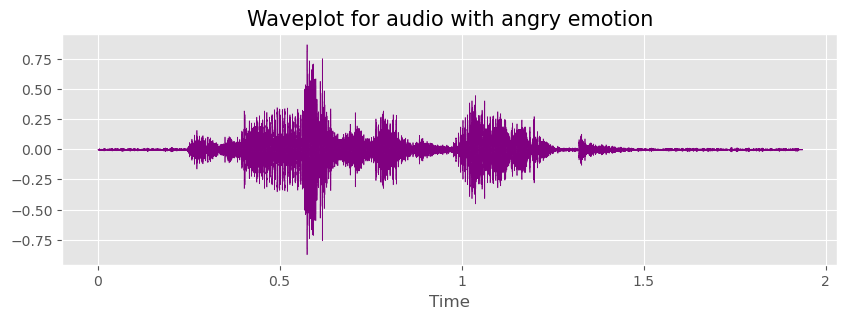

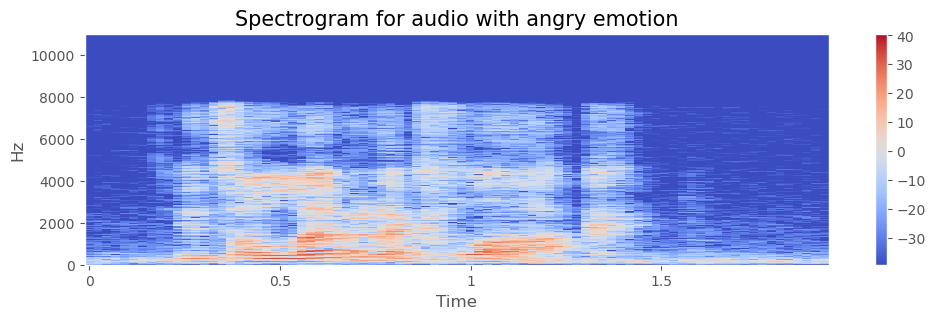

In [10]:
emotion='angry'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

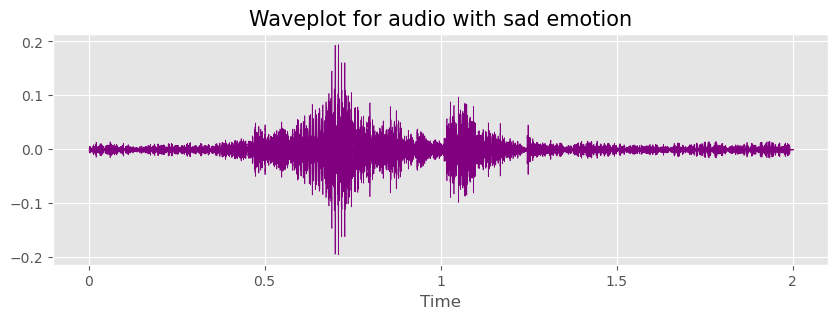

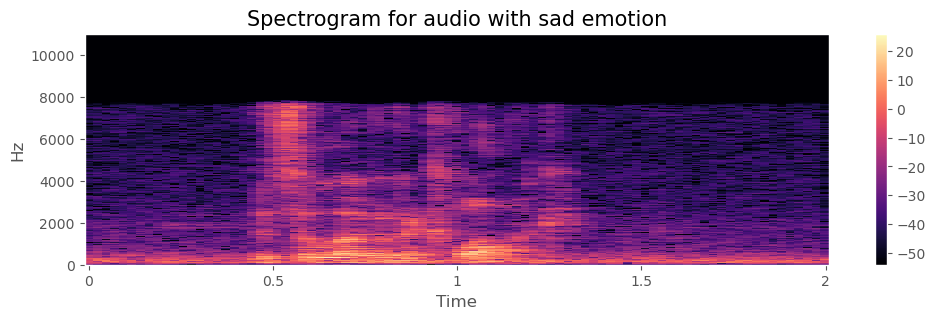

In [11]:
emotion='sad'
path = np.array(df.Path[df.Emotion==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

# Data Augmentation
Data augmentation is the process by which we create new synthetic data samples by adding small perturbations on our initial training set.

There are lot of ways for data augmentation in sound data, we will use following in this project:

1. Noise injection
2. Stretching
3. Shifting
4. Pitching

Data augmentation is a technique commonly used in machine learning, including sentiment analysis on audio data, 
for several important reasons:

Increased Training Data: Data augmentation allows you to artificially increase the size of your training dataset 
    by creating new, slightly modified versions of existing data. This is especially beneficial 
    when you have limited labeled data available for training. More data can lead to better model generalization and performance.

Robustness to Variability: Real-world audio data can vary significantly due to different 
    recording conditions, speakers, accents, background noise, and more. Augmenting the data with variations 
    helps the model become more robust to these sources of variability, making it better at handling different input scenarios.

Reduced Overfitting: Augmentation introduces diversity into the training dataset, which can help prevent overfitting. 
    When a model is trained on a larger and more diverse set of examples, it is less likely to memorize the training data 
    and can generalize better to unseen data.

Improved Model Generalization: Data augmentation helps the model learn more invariant and discriminative features by
    exposing it to different variations of the same data. This can result in a model that generalizes better to real-world data.

Mitigation of Class Imbalance: In sentiment analysis, there can be class imbalance issues, where some sentiments 
    are underrepresented in the dataset. Augmentation can balance the classes by generating additional examples 
    for the minority class, improving model performance on all classes.

Noise Robustness: Adding various types of noise to the audio data during augmentation can help the model become more robust 
    to different levels and types of noise commonly encountered in real-world scenarios.

Data Diversity: Augmentation techniques can simulate different speaking styles, emotional tones, or linguistic variations 
    that may be present in natural conversations. This ensures that the model learns to recognize sentiments across a wide 
    range of real-world scenarios.

Enhanced Learning of Invariances: Data augmentation can help the model learn important invariances in the data, 
    such as recognizing sentiment based on speech patterns rather than specific acoustic features that may 
    vary across recordings.

Common data augmentation techniques for audio data in sentiment analysis include:

Pitch Shifting: Altering the pitch of the audio, which simulates variations in the speaker's tone or pitch.
Time Stretching: Adjusting the speed or duration of the audio, mimicking variations in speaking rate.
Noise Injection: Adding background noise to the audio to simulate real-world acoustic conditions.
Speed Perturbation: Slightly changing the playback speed, which can simulate different speaking rates.
Volume and Amplitude Variations: Adjusting the volume or amplitude of the audio.
Time Warping: Slightly warping the time axis of the audio signal.
By applying these augmentation techniques, you can create a more diverse and representative training dataset, 
leading to improved sentiment analysis models that perform better on a wide range of audio data from various 
sources and conditions.

In [12]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate=0.5)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor, random=False):
    """"Add some pitch to sound sample. Use random if you want to add random pitch with some threshold.
    Or use pitch_factor Random=False and rate for always adding fixed pitch."""
    if random:
        pitch_factor=np.random.random() * pitch_factor
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

In [13]:
# Taking one sample from the dataset to check Data Augmentation techniques

path = df[df["Emotion"] == "happy"]["Path"].iloc[0]
data, sampling_rate = librosa.load(path)

1. Simple Audio

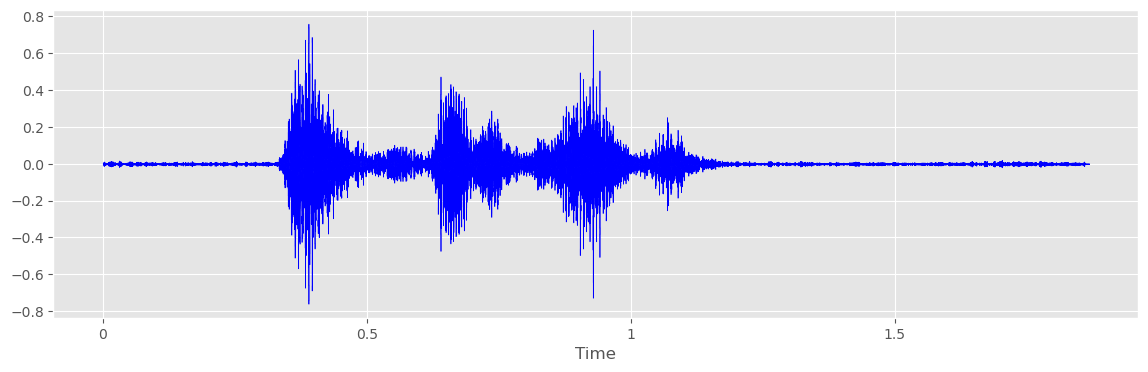

In [14]:
plt.figure(figsize=(14,4))
librosa.display.waveshow(data, sr=sampling_rate, color="blue")
Audio(path)

2. Noisy data

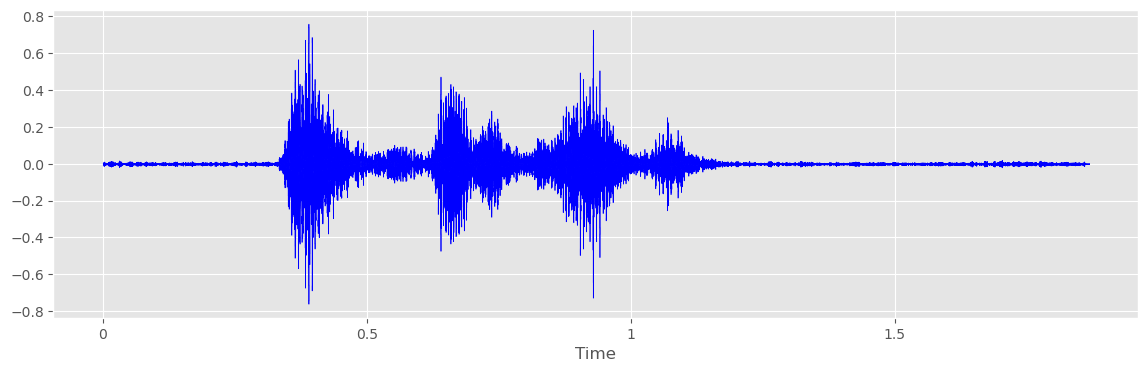

In [15]:
noised_data = noise(data, random=True)
plt.figure(figsize=(14,4))
librosa.display.waveshow(noised_data, sr=sampling_rate, color="blue")
Audio(noised_data, rate=sampling_rate)

3. Stretching

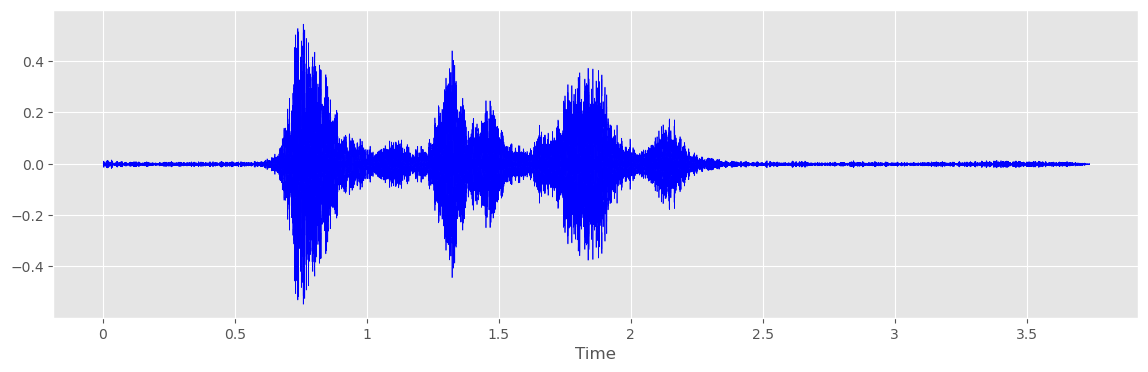

In [16]:

stretched_data = stretch(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(stretched_data, sr=sampling_rate, color="blue")
Audio(stretched_data, rate=sampling_rate)

4. Shifting

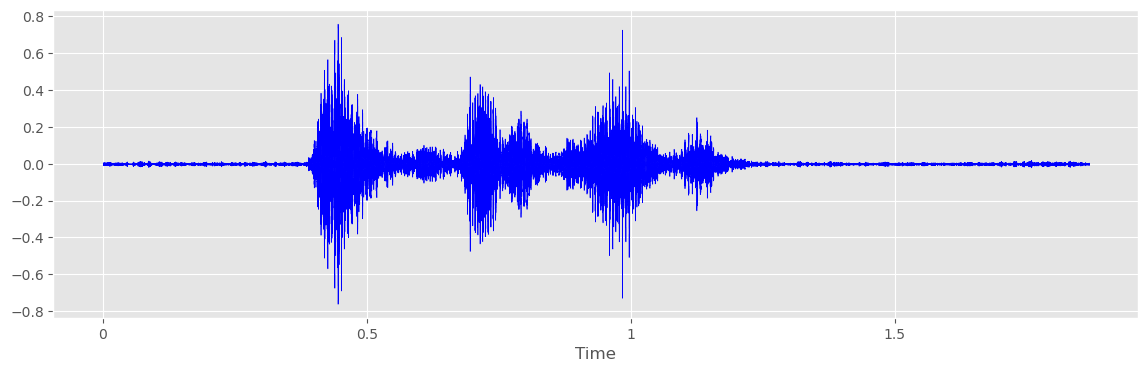

In [17]:
shifted_data = shift(data)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=shifted_data, sr=sampling_rate, color="blue")
Audio(shifted_data, rate=sampling_rate)

5. Pitching

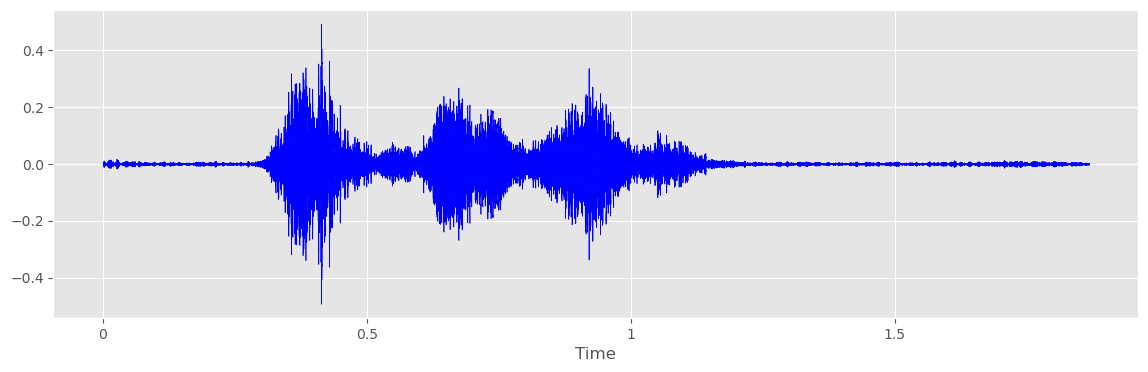

In [18]:
pitched_data = pitch(data, sampling_rate, pitch_factor=3,random=False)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=pitched_data, sr=sampling_rate, color="blue")
Audio(pitched_data, rate=sampling_rate)

# Feature Extraction
Extraction of features is a very important part in analyzing and finding relations between different things. As we already know that the data provided of audio cannot be understood by the models directly so we need to convert them into an understandable format for which feature extraction is used.

The audio signal is a three-dimensional signal in which three axes represent time, amplitude and frequency.

There are several data transormation methods with the help of sample rate and sample data are as follow:

1. Zero Crossing Rate : The rate of sign-changes of the signal during the duration of a particular frame.
2. Energy : The sum of squares of the signal values, normalized by the respective frame length.
3. Entropy of Energy :The entropy of sub-frames’ normalized energies. It can be interpreted as a measure of abrupt changes.
4. Spectral Centroid : The center of gravity of the spectrum.
5. Spectral Spread : The second central moment of the spectrum.
6. Spectral Entropy : Entropy of the normalized spectral energies for a set of sub-frames.
7. Spectral Flux : The squared difference between the normalized magnitudes of the spectra of the    two successive frames.
8. Spectral Rolloff : The frequency below which 90% of the magnitude distribution of the spectrum    is concentrated.
9. MFCCs Mel Frequency Cepstral Coefficients form a cepstral representation where the frequency      bands are not linear but distributed according to the mel-scale.

Mel-Frequency Cepstral Coefficients (MFCCs): MFCCs are widely used in audio processing. 
    They capture the spectral characteristics of audio signals, including the distribution of energy 
    in different frequency bands. Typically, a set of MFCCs is extracted from short segments of audio, 
    resulting in a sequence of MFCC vectors that can be used as features.
    
Zero-Crossing Rate: This feature counts the number of times the audio signal crosses the zero amplitude line. 
    It provides information about the noisiness and rapid changes in the audio.

RMS Energy: Root Mean Square (RMS) energy measures the energy or loudness of the audio signal. 
    It can capture variations in the intensity of speech or emotion.

In [20]:
n_fft = 2048
hop_length = 512

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In this project we will use 3 main Data Transformation features : ZCR, RMS and MFCC.

Also we will use just 2.5s duration with 0.6 offset. In the dataset first 0.6s contains no information about emotion, and most of them are less then 3s.

In [26]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        ))
    return result

In [27]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

#     # data with pitching
    pitched_data = pitch(data, sample_rate, pitch_factor=3, random=False)
    
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

#     # data with pitching and noise
    new_data = pitch(data, sample_rate, pitch_factor=3, random=False)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result

In [28]:
X, Y = [], []
for path, emotion in zip(df.Path, df.Emotion):
    features = get_features(path)
    for ele in features:
        X.append(ele)
        Y.append(emotion)

In [30]:
print(len(X))

29768


In [31]:
print(len(Y))

29768


In [32]:
features_path = "features1.csv"

In [33]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.to_csv(features_path, index=False)

In [34]:
extracted_df = pd.read_csv("features1.csv")
print(extracted_df.shape)

(29768, 2377)


In [36]:
extracted_df

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.034180,0.069336,0.115723,0.148926,0.142090,0.130859,0.101562,0.070801,0.069336,0.074219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
1,0.104492,0.186523,0.279785,0.308105,0.260254,0.204102,0.131836,0.097168,0.125977,0.136719,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
2,0.042969,0.088867,0.145020,0.161133,0.149902,0.131348,0.090820,0.077148,0.094238,0.087891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
3,0.050781,0.102539,0.159668,0.172852,0.159668,0.136719,0.094727,0.082031,0.099121,0.091797,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
4,0.041504,0.059082,0.070312,0.062988,0.080566,0.128906,0.145508,0.146484,0.125977,0.072266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29763,0.069824,0.146484,0.258301,0.368164,0.453125,0.520020,0.522949,0.446777,0.356934,0.238281,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,neutral
29764,0.216309,0.252441,0.308105,0.197266,0.123047,0.103516,0.067871,0.074707,0.070801,0.068359,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
29765,0.228027,0.308105,0.382324,0.274414,0.198242,0.144531,0.096191,0.107910,0.122070,0.150391,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad
29766,0.249023,0.324219,0.355957,0.238770,0.154297,0.099609,0.090820,0.084473,0.086426,0.083008,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,sad


In [35]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0         False
1         False
2         False
3         False
4         False
          ...  
2372      False
2373      False
2374      False
2375      False
labels    False
Length: 2377, dtype: bool


(29768, 2377)

In [35]:
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2367,2368,2369,2370,2371,2372,2373,2374,2375,labels
0,0.034180,0.069336,0.115723,0.148926,0.142090,0.130859,0.101562,0.070801,0.069336,0.074219,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
1,0.159180,0.247559,0.364746,0.379883,0.316895,0.263672,0.182617,0.153809,0.210449,0.222656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
2,0.042969,0.088867,0.145020,0.161133,0.149902,0.131348,0.090820,0.077148,0.094238,0.087891,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
3,0.142090,0.243164,0.336914,0.333496,0.273926,0.215332,0.158691,0.146484,0.189453,0.174805,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,angry
4,0.041504,0.059082,0.070312,0.062988,0.080566,0.128906,0.145508,0.146484,0.125977,0.072266,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,disgust


# Data Preparation
As of now we have extracted the data, now we need to normalize and split our data for training and testing.

In [37]:
X = extracted_df.drop(labels="labels", axis=1)
Y = extracted_df["labels"]

In [38]:
# Encoding Emotion Labels with LabelEncoder()

lb = LabelEncoder()
Y = to_categorical(lb.fit_transform(Y))
print(lb.classes_)
Y

['angry' 'disgust' 'fear' 'happy' 'neutral' 'sad']


array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [41]:
# Splitting data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23814, 2376), (5954, 2376), (23814, 6), (5954, 6))

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, shuffle=True)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((21432, 2376), (5954, 2376), (2382, 2376), (21432, 6), (5954, 6), (2382, 6))

In [43]:
# Feature Scaling using Standard Scaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((21432, 2376), (5954, 2376), (2382, 2376), (21432, 6), (5954, 6), (2382, 6))

In [45]:
# We have to use 1-dimensional CNN for which we need specific shape
X_train = np.expand_dims(X_train, axis=2)
X_val = np.expand_dims(X_val, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(21432, 2376, 1)

# Let's define our model:

In [46]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization, LSTM, Bidirectional
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import visualkeras

In [48]:
model = Sequential()
model.add(layers.Conv1D(128, kernel_size=3, strides=1,
                        padding="same", activation="relu",
                        input_shape=(X_train.shape[1], 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPool1D(pool_size=5, strides=2, padding="same"))

model.add(layers.Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling1D(pool_size=3, strides = 2, padding = 'same'))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(6, activation="softmax"))


model.compile(optimizer = 'Adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 2376, 128)         512       
                                                                 
 batch_normalization_3 (Bat  (None, 2376, 128)         512       
 chNormalization)                                                
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 1188, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_3 (Conv1D)           (None, 1188, 128)         49280     
                                                                 
 batch_normalization_4 (Bat  (None, 1188, 128)         512       
 chNormalization)                                                
                                                      

In [49]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
history=model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_val, y_val), callbacks=[rlrp])

Epoch 1/20
335/335 [==============================] - 694s 2s/step - loss: 1.5056 - accuracy: 0.4022 - val_loss: 1.7342 - val_accuracy: 0.3044 - lr: 0.0010
Epoch 2/20
335/335 [==============================] - 651s 2s/step - loss: 1.2923 - accuracy: 0.4843 - val_loss: 1.3472 - val_accuracy: 0.4635 - lr: 0.0010
Epoch 3/20
335/335 [==============================] - 652s 2s/step - loss: 1.1775 - accuracy: 0.5395 - val_loss: 1.2916 - val_accuracy: 0.4929 - lr: 0.0010
Epoch 4/20
335/335 [==============================] - 650s 2s/step - loss: 1.0200 - accuracy: 0.6092 - val_loss: 1.2283 - val_accuracy: 0.5218 - lr: 0.0010
Epoch 5/20
335/335 [==============================] - 643s 2s/step - loss: 0.8438 - accuracy: 0.6885 - val_loss: 1.0455 - val_accuracy: 0.5936 - lr: 0.0010
Epoch 6/20
335/335 [==============================] - 644s 2s/step - loss: 0.6207 - accuracy: 0.7778 - val_loss: 1.1435 - val_accuracy: 0.5919 - lr: 0.0010
Epoch 7/20
335/335 [==============================] - 647s 2s/st

187/187 [==============================] - 37s 196ms/step - loss: 0.7249 - accuracy: 0.8112
Accuracy of our model on test data :  81.12 %


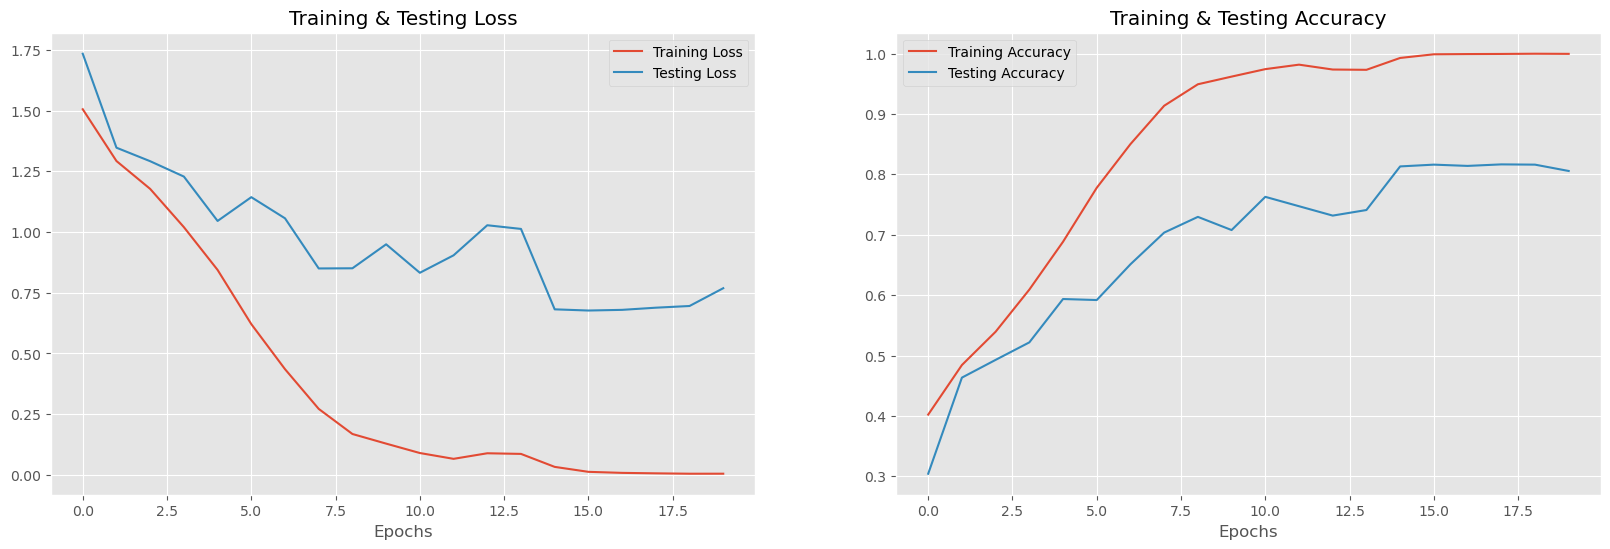

In [50]:
print("Accuracy of our model on test data : " , round(model.evaluate(X_test,y_test)[1]*100,2) , "%")

epochs = [i for i in range(20)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")

plt.show()

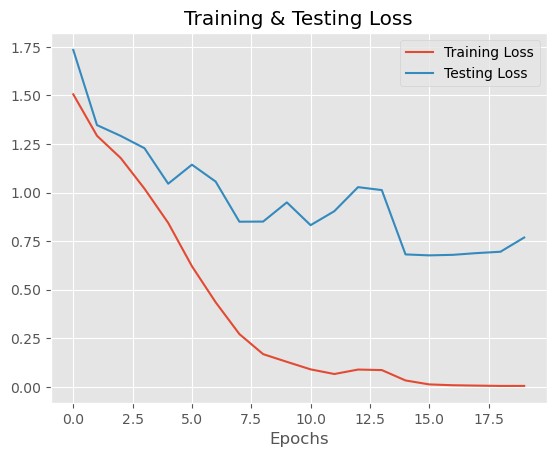

In [51]:
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss')
plt.legend()
plt.xlabel("Epochs")
plt.show()

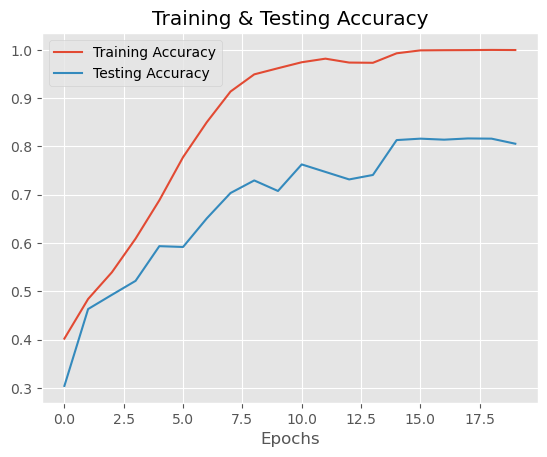

In [52]:
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.show()

In [53]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred_class = [lb.classes_[idx] for idx in y_pred ]

187/187 [==============================] - 37s 195ms/step


In [54]:
y_test_class = np.argmax(y_test, axis=1)
y_test_class = [lb.classes_[idx] for idx in y_test_class ]

In [55]:
result = pd.DataFrame({"Actual":y_test_class, "Predicted":y_pred_class})
result

,Actual,Predicted
0,angry,angry
1,happy,happy
2,disgust,disgust
3,angry,fear
4,disgust,disgust
...,...,...
5949,angry,fear
5950,neutral,neutral
5951,happy,happy
5952,happy,angry


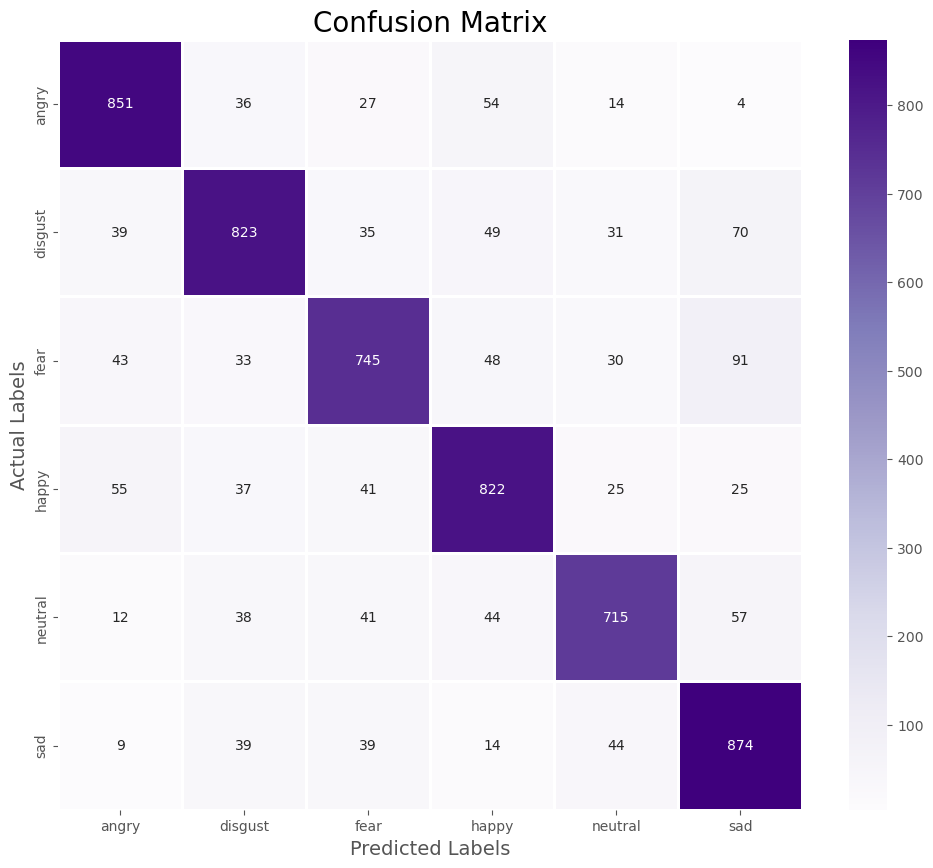

In [56]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_class, y_pred_class)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in lb.classes_] , columns = [i for i in lb.classes_])
sns.heatmap(cm, linecolor='white', cmap='Purples', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [57]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

       angry       0.84      0.86      0.85       986
     disgust       0.82      0.79      0.80      1047
        fear       0.80      0.75      0.78       990
       happy       0.80      0.82      0.81      1005
     neutral       0.83      0.79      0.81       907
         sad       0.78      0.86      0.82      1019

    accuracy                           0.81      5954
   macro avg       0.81      0.81      0.81      5954
weighted avg       0.81      0.81      0.81      5954



In [58]:
print(X_test)

[[[-0.24668743]
  [-0.28498728]
  [-0.34319543]
  ...
  [ 0.20834239]
  [ 0.15775387]
  [ 0.15819162]]

 [[-0.36003583]
  [-0.45282711]
  [-0.50149847]
  ...
  [ 0.20834239]
  [ 0.15775387]
  [ 0.15819162]]

 [[-0.52569887]
  [-0.57870698]
  [-0.59927388]
  ...
  [ 0.20834239]
  [ 0.15775387]
  [ 0.15819162]]

 ...

 [[-0.67392369]
  [-0.65663262]
  [-0.50615444]
  ...
  [ 0.20834239]
  [ 0.15775387]
  [ 0.15819162]]

 [[-0.04614797]
  [-0.19507308]
  [-0.250076  ]
  ...
  [ 0.20834239]
  [ 0.15775387]
  [ 0.15819162]]

 [[ 1.61920152]
  [ 1.53127947]
  [ 1.48660146]
  ...
  [ 0.20834239]
  [ 0.15775387]
  [ 0.15819162]]]


In [61]:
model.save('model.h5')


C:\Users\rahul\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
